<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/experiments_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [281]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

!pip install dict_minimize
from dict_minimize.torch_api import minimize
from collections import OrderedDict

# Helpers for plotting the trajectories of the weights of the neurons

In [282]:
def plot_trajectories(data_row):
  convergence_neurons_incoming_x = []
  convergence_neurons_incoming_y = []
  convergence_neurons_outgoing = []

  for i in range(0, int(data_row['student size'])):
    neuron_traj_x = np.fromstring(data_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')
    plt.plot(neuron_traj_x, neuron_traj_y)
  
    convergence_neurons_incoming_x.append(neuron_traj_x[-1])
    convergence_neurons_incoming_y.append(neuron_traj_y[-1])

    neuron_a = float(data_row['neuron_' + str(i) + '_a'].values[0])
    convergence_neurons_outgoing.append(neuron_a)

  teacher_neurons_x = np.fromstring(data_row['teacher_neurons_x'].values[0][1 : -1], dtype=float, sep=',')
  teacher_neurons_y = np.fromstring(data_row['teacher_neurons_y'].values[0][1 : -1], dtype=float, sep=',')
  plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

  plt.scatter(convergence_neurons_incoming_x,
            convergence_neurons_incoming_y,
            c = convergence_neurons_outgoing,
            cmap=matplotlib.cm.jet)
  plt.colorbar()

# Read the data from the .csv file

In [283]:
data = pd.read_csv('experiments_data_student_5_outgoing_1_-1.csv')

# TODO: remove these check and make sure the Hessian is not complex/
data['smallest eigenvalue'] = pd.to_numeric(data['smallest eigenvalue'], 'coerce')
print("Number of complex eigenvalues:", len(data[data['smallest eigenvalue'].isna()]))
data = data[data['smallest eigenvalue'].notna()]
data['loss'] = pd.to_numeric(data['loss'], 'coerce')
data = data[data['loss'].notna()]
data['gradient norm'] = pd.to_numeric(data['gradient norm'], 'coerce')
data = data[data['gradient norm'].notna()]

len(data)

Number of complex eigenvalues: 0


1000

In [284]:
data.head()

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
0,1.006376e-04,0.000002,1.765515e-06,5,"[0.28767657, 0.28877622, 0.28977433, 0.2907698...","[-0.18215978, -0.18106024, -0.1800628, -0.1790...",0.957795,"[-0.09641838, -0.09751794, -0.09851552, -0.099...","[0.028319359, 0.027219947, 0.02622314, 0.02523...",-0.703778,"[0.7649002, 0.76380044, 0.762802, 0.76180565, ...","[-0.21563697, -0.21673651, -0.21773396, -0.218...",-0.613305,"[-0.55468154, -0.55578107, -0.55677843, -0.557...","[-0.35145217, -0.35035077, -0.3493434, -0.3483...",-0.378024,"[0.039734304, 0.038634636, 0.037636437, 0.0366...","[0.6528094, 0.65170956, 0.6507107, 0.64971346,...",0.737312,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
1,1.126247e-04,0.000001,9.960524e-07,5,"[0.6270397, 0.6281397, 0.6291391, 0.6301378, 0...","[0.3499837, 0.3488839, 0.34788468, 0.34688655,...",0.789879,"[0.7292756, 0.73037523, 0.73137325, 0.7323685,...","[-0.4977684, -0.49666855, -0.49566886, -0.4946...",-0.538845,"[0.054563224, 0.055660132, 0.056642722, 0.0575...","[-0.18021291, -0.17911296, -0.17811319, -0.177...",-0.736179,"[0.8172325, 0.8183327, 0.8193324, 0.820332, 0....","[0.85530114, 0.854201, 0.85320145, 0.8522023, ...",0.095402,"[0.46468723, 0.46358803, 0.46259242, 0.4616029...","[-0.82113993, -0.82223946, -0.8232366, -0.8242...",0.389741,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
2,1.806034e-07,0.000002,3.960682e-06,5,"[-0.51757467, -0.5164745, -0.5154743, -0.51447...","[-0.35152346, -0.3504236, -0.34942412, -0.3484...",-0.772029,"[-0.6766824, -0.67558223, -0.674582, -0.673581...","[-0.063059926, -0.061960008, -0.06096048, -0.0...",0.755787,"[0.23974037, 0.2386402, 0.23763928, 0.2366371,...","[0.63002634, 0.628926, 0.6279242, 0.62691987, ...",-1.871027,"[0.7474017, 0.74850154, 0.7495002, 0.75049704,...","[-0.58115554, -0.5800557, -0.5790568, -0.57805...",0.937195,"[0.8465413, 0.847641, 0.84863925, 0.8496352, 0...","[-0.36297798, -0.3618783, -0.36087987, -0.3598...",0.950076,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
3,7.373002e-05,0.000001,-3.081212e-06,5,"[-0.6786128, -0.6797141, -0.68072075, -0.68173...","[0.43527937, 0.43417957, 0.43318036, 0.4321822...",0.637927,"[0.017915964, 0.01901525, 0.020011375, 0.02100...","[-0.6100751, -0.61117464, -0.6121718, -0.61316...",-0.199785,"[0.25231147, 0.2534108, 0.25440735, 0.2553993,...","[0.21730137, 0.21620166, 0.21520329, 0.2142071...",1.209803,"[-0.8822162, -0.88331527, -0.88430977, -0.8852...","[-0.053145587, -0.0520458, -0.05104695, -0.050...",-1.166978,"[-0.22924155, -0.23034127, -0.23133972, -0.232...","[-0.5169028, -0.5158026, -0.514803, -0.5138035...",-0.480965,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
4,1.449932e-07,0.000002,4.746581e-06,5,"[-0.44546103, -0.44656086, -0.44756013, -0.448...","[-0.13755757, -0.13645796, -0.13546014, -0.134...",-0.955887,"[-0.80359375, -0.8024913, -0.80147845, -0.8004...","[-0.41036063, -0.41146284, -0.41247454, -0.413...",0.791203,"[-0.9198052, -0.91870445, -0.9177007, -0.91669...","[0.18736243, 0.18626273, 0.18526436, 0.1842682...",1.883984,"[-0.90803325, -0.9091343, -0.9101399, -0.91115...","[0.46909237, 0.47019148, 0.4711866, 0.47217497...",-0.943731,"[-0.11110473, -0.11220479, -0.113205105, -0.11...","[-0.3013839, -0.3002842, -0.29928556, -0.29828...",-0.775570,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


# Second order optimization helpers

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [285]:
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

Some configuration for the model, the dataset and the corresponding labels.

In [286]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [287]:
D_in, H_teacher, H_student, D_out = 2, 4, data['student size'].values[0], 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.Tensor(construct_dataset()) 
print(len(construct_dataset()))

1681


In [288]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

Function useful for computing the Hessian.

In [289]:
def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    grad_norm = torch.norm(g_vector)
    l = g_vector.size(0)
    hessian = torch.zeros(l, l)
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd: 
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
    hessian = (hessian + hessian.T) / 2
    return grad_norm.cpu().data.numpy(), hessian.cpu().data.numpy()

A method which computes the derivatives of the objective loss with respect to the incoming and outgoing weights.

In [290]:
def d_loss(params):
  w_in, w_out = params["w_in"], params["w_out"]
  dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
  obj = nn.MSELoss()(dummy_model(dataset), y_labels)
  dw_in, dw_out = torch.autograd.grad(obj, dummy_model.parameters())
  d_obj = OrderedDict([("w_in", dw_in), ("w_out", dw_out)])
  return obj, d_obj

# Case 1: positive eigenvalues

This is certainly:
- either a local minimum
- or a global minimum

In [291]:
positive_eigenvalues_data = data[data['smallest eigenvalue'] >= 0]
positive_eigenvalues_data.head()

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
0,1.006376e-04,1.688412e-06,1.765515e-06,5,"[0.28767657, 0.28877622, 0.28977433, 0.2907698...","[-0.18215978, -0.18106024, -0.1800628, -0.1790...",0.957795,"[-0.09641838, -0.09751794, -0.09851552, -0.099...","[0.028319359, 0.027219947, 0.02622314, 0.02523...",-0.703778,"[0.7649002, 0.76380044, 0.762802, 0.76180565, ...","[-0.21563697, -0.21673651, -0.21773396, -0.218...",-0.613305,"[-0.55468154, -0.55578107, -0.55677843, -0.557...","[-0.35145217, -0.35035077, -0.3493434, -0.3483...",-0.378024,"[0.039734304, 0.038634636, 0.037636437, 0.0366...","[0.6528094, 0.65170956, 0.6507107, 0.64971346,...",0.737312,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
1,1.126247e-04,1.109269e-06,9.960524e-07,5,"[0.6270397, 0.6281397, 0.6291391, 0.6301378, 0...","[0.3499837, 0.3488839, 0.34788468, 0.34688655,...",0.789879,"[0.7292756, 0.73037523, 0.73137325, 0.7323685,...","[-0.4977684, -0.49666855, -0.49566886, -0.4946...",-0.538845,"[0.054563224, 0.055660132, 0.056642722, 0.0575...","[-0.18021291, -0.17911296, -0.17811319, -0.177...",-0.736179,"[0.8172325, 0.8183327, 0.8193324, 0.820332, 0....","[0.85530114, 0.854201, 0.85320145, 0.8522023, ...",0.095402,"[0.46468723, 0.46358803, 0.46259242, 0.4616029...","[-0.82113993, -0.82223946, -0.8232366, -0.8242...",0.389741,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
2,1.806034e-07,1.901193e-06,3.960682e-06,5,"[-0.51757467, -0.5164745, -0.5154743, -0.51447...","[-0.35152346, -0.3504236, -0.34942412, -0.3484...",-0.772029,"[-0.6766824, -0.67558223, -0.674582, -0.673581...","[-0.063059926, -0.061960008, -0.06096048, -0.0...",0.755787,"[0.23974037, 0.2386402, 0.23763928, 0.2366371,...","[0.63002634, 0.628926, 0.6279242, 0.62691987, ...",-1.871027,"[0.7474017, 0.74850154, 0.7495002, 0.75049704,...","[-0.58115554, -0.5800557, -0.5790568, -0.57805...",0.937195,"[0.8465413, 0.847641, 0.84863925, 0.8496352, 0...","[-0.36297798, -0.3618783, -0.36087987, -0.3598...",0.950076,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
4,1.449932e-07,2.046076e-06,4.746581e-06,5,"[-0.44546103, -0.44656086, -0.44756013, -0.448...","[-0.13755757, -0.13645796, -0.13546014, -0.134...",-0.955887,"[-0.80359375, -0.8024913, -0.80147845, -0.8004...","[-0.41036063, -0.41146284, -0.41247454, -0.413...",0.791203,"[-0.9198052, -0.91870445, -0.9177007, -0.91669...","[0.18736243, 0.18626273, 0.18526436, 0.1842682...",1.883984,"[-0.90803325, -0.9091343, -0.9101399, -0.91115...","[0.46909237, 0.47019148, 0.4711866, 0.47217497...",-0.943731,"[-0.11110473, -0.11220479, -0.113205105, -0.11...","[-0.3013839, -0.3002842, -0.29928556, -0.29828...",-0.775570,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
5,9.475512e-08,9.220086e-07,5.865642e-08,5,"[0.15436018, 0.15325813, 0.15224731, 0.1512222...","[-0.15222347, -0.1511215, -0.15011103, -0.1490...",-0.998668,"[0.57760036, 0.5787001, 0.5796986, 0.5806951, ...","[0.7720529, 0.77095306, 0.7699542, 0.76895696,...",0.354275,"[-0.06631923, -0.06521961, -0.06422168, -0.063...","[-0.43605936, -0.43715885, -0.4381562, -0.4391...",-0.772408,"[0.20043874, 0.20153858, 0.20253764, 0.2035354...","[0.48196518, 0.48086536, 0.4798661, 0.47886783...",0.650585,"[0.08144486, 0.08254448, 0.08354245, 0.0845376...","[-0.15963101, -0.16073057, -0.1617282, -0.1627...",0.766216,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


## Choose the entry with the highest loss for visual inspection.

In [292]:
highest_loss_row = positive_eigenvalues_data[positive_eigenvalues_data['loss'] == 
                          max(positive_eigenvalues_data['loss'])]
highest_loss_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
554,0.00012,0.000002,5.891521e-08,5,"[-0.30611193, -0.30721113, -0.30820677, -0.309...","[-0.68524516, -0.6841463, -0.68315196, -0.6821...",-0.442123,"[0.262923, 0.2618237, 0.26082763, 0.2598369, 0...","[0.11894119, 0.120039746, 0.12103175, 0.122012...",-0.301189,"[-0.56262696, -0.56372607, -0.5647216, -0.5657...","[0.08642709, 0.0875252, 0.08851475, 0.08948958...",-0.168002,"[-0.22946602, -0.22836682, -0.22737116, -0.226...","[-0.84010166, -0.8412004, -0.8421935, -0.84317...",1.200516,"[-0.18552661, -0.18662581, -0.1876214, -0.1886...","[0.058314264, 0.059412554, 0.06040313, 0.06138...",-0.289486,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


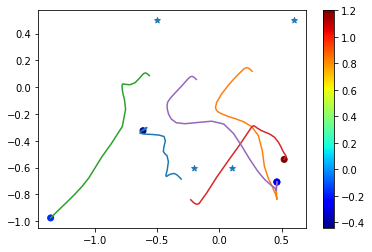

In [293]:
plot_trajectories(highest_loss_row)

## Choose the entry with the lowest loss for visual inspection.

In [294]:
lowest_loss_row = positive_eigenvalues_data[positive_eigenvalues_data['loss'] == 
                          min(positive_eigenvalues_data['loss'])]
lowest_loss_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
226,1.717876e-10,7.971313e-07,2.930291e-07,5,"[-0.7122008, -0.711101, -0.7101022, -0.7091051...","[-0.318281, -0.31938076, -0.3203797, -0.321377...",-0.999158,"[-0.7135771, -0.712477, -0.71147746, -0.710478...","[0.58482254, 0.5859225, 0.5869218, 0.5879203, ...",0.998727,"[-0.7779258, -0.7768258, -0.77582633, -0.77482...","[-0.58277345, -0.58387333, -0.5848725, -0.5858...",0.698262,"[-0.46316257, -0.46426243, -0.4652623, -0.4662...","[0.7826747, 0.7815745, 0.78057396, 0.77957267,...",-0.998734,"[-0.882863, -0.88176304, -0.88076365, -0.87976...","[-0.2913239, -0.29242375, -0.29342362, -0.2944...",0.300903,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


In [295]:
w_in = []
w_out = []

for i in range(0, int(lowest_loss_row['student size'])):
  neuron_traj_x = np.fromstring(lowest_loss_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
  neuron_traj_y = np.fromstring(lowest_loss_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')

  w_in.append([neuron_traj_x[-1], neuron_traj_y[-1]])

  w_out.append(float(lowest_loss_row['neuron_' + str(i) + '_a'].values[0]))

w_out = [w_out]

print(w_in)
print(w_out)

[[-0.6002194, -0.50006455], [-0.099743515, 0.6003923], [-0.196829, -0.59945375], [-0.5002848, 0.5000267], [-0.20700243, -0.6025387]]
[[-0.9991581, 0.9987267, 0.6982621999999999, -0.99873406, 0.30090275]]


In [296]:
params = OrderedDict([("w_in", torch.Tensor(w_in)), ("w_out", torch.Tensor(w_out))])
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])

In [297]:
test_data = torch.Tensor([1000, 1000])
print(dummy_model(test_data))
print(teacher_model(test_data))

tensor([0.5634], grad_fn=<SqueezeBackward3>)
tensor([0.5000], grad_fn=<SqueezeBackward3>)


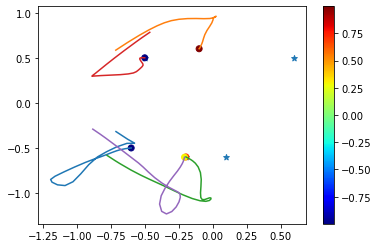

In [298]:
plot_trajectories(lowest_loss_row)

# Case 2: negative eigenvalues

In [299]:
negative_eigenvalues_data = data[data['smallest eigenvalue'] <= 0]
negative_eigenvalues_data.head()

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
3,7.373002e-05,1.299365e-06,-3.081212e-06,5,"[-0.6786128, -0.6797141, -0.68072075, -0.68173...","[0.43527937, 0.43417957, 0.43318036, 0.4321822...",0.637927,"[0.017915964, 0.01901525, 0.020011375, 0.02100...","[-0.6100751, -0.61117464, -0.6121718, -0.61316...",-0.199785,"[0.25231147, 0.2534108, 0.25440735, 0.2553993,...","[0.21730137, 0.21620166, 0.21520329, 0.2142071...",1.209803,"[-0.8822162, -0.88331527, -0.88430977, -0.8852...","[-0.053145587, -0.0520458, -0.05104695, -0.050...",-1.166978,"[-0.22924155, -0.23034127, -0.23133972, -0.232...","[-0.5169028, -0.5158026, -0.514803, -0.5138035...",-0.480965,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
12,1.148570e-04,1.947127e-06,-6.076706e-08,5,"[0.88523614, 0.88633597, 0.88733476, 0.8883318...","[0.6706927, 0.6695928, 0.66859376, 0.667596, 0...",0.075265,"[0.03439802, 0.033297714, 0.03229608, 0.031292...","[-0.17208314, -0.170983, -0.1699823, -0.168980...",-0.603175,"[-0.27339393, -0.27449548, -0.27550375, -0.276...","[-0.60061294, -0.5995113, -0.5985031, -0.59748...",-0.200969,"[0.7260444, 0.72494555, 0.72395146, 0.7229657,...","[-0.5417014, -0.542801, -0.543799, -0.5447941,...",0.343798,"[0.12642407, 0.1275241, 0.12852426, 0.12952465...","[0.77003133, 0.76893115, 0.76793146, 0.7669319...",0.385074,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
13,1.141731e-04,9.969041e-07,-2.990608e-08,5,"[0.86080384, 0.85970366, 0.85870326, 0.8577022...","[-0.6272156, -0.6283158, -0.629316, -0.6303166...",-1.455881,"[-0.6480992, -0.646999, -0.64599884, -0.644998...","[-0.14023715, -0.14133722, -0.14233753, -0.143...",0.420410,"[-0.557319, -0.55621904, -0.5552196, -0.554220...","[-0.80498934, -0.80608916, -0.8070881, -0.8080...",0.433547,"[-0.2181974, -0.21709754, -0.21609828, -0.2151...","[0.5636673, 0.5647669, 0.5657646, 0.566759, 0....",0.479802,"[0.66613173, 0.6672315, 0.66822994, 0.6692261,...","[0.32170916, 0.32060945, 0.319611, 0.3186147, ...",0.122454,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
19,1.735169e-07,1.551616e-06,-4.156950e-08,5,"[0.17383587, 0.17493583, 0.17593554, 0.1769348...","[0.65492964, 0.6560289, 0.65702474, 0.6580148,...",0.998790,"[0.6043483, 0.60324836, 0.602249, 0.6012506, 0...","[0.8840395, 0.88513935, 0.8861383, 0.88713586,...",-0.774685,"[-0.8169331, -0.8158329, -0.81483275, -0.81383...","[0.19977367, 0.20087363, 0.20187332, 0.2028725...",0.762726,"[-0.7117446, -0.7128448, -0.71384495, -0.71484...","[0.8463285, 0.8452283, 0.84422797, 0.8432271, ...",-0.986922,"[-0.22165132, -0.22055143, -0.21955208, -0.218...","[-0.58339965, -0.5822989, -0.5812948, -0.58028...",0.000092,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
20,1.168536e-04,1.716826e-06,-9.012151e-07,5,"[-0.48156473, -0.48266366, -0.4836579, -0.4846...","[0.87009275, 0.86899346, 0.86799765, 0.8670077...",-0.335444,"[-0.22550035, -0.22439602, -0.22337356, -0.222...","[-0.042183995, -0.043288216, -0.044310063, -0....",0.331979,"[0.41804266, 0.4169428, 0.41594335, 0.41494465...","[-0.38739896, -0.38629946, -0.38530195, -0.384...",0.118717,"[0.06406069, 0.06296102, 0.06196284, 0.0609671...","[-0.48657867, -0.48547903, -0.4844806, -0.4834...",0.299856,"[0.017664671, 0.01656477, 0.015565304, 0.01456...","[-0.732383, -0.73128283, -0.73028266, -0.72928...",-0.415097,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


In [300]:
len(negative_eigenvalues_data)

347

## Choose an experiment with the (negative) eigenvalue with the highest magnitude - indicative of a saddle.

In [301]:
smallest_neg_eigenvalue_row = negative_eigenvalues_data[negative_eigenvalues_data['smallest eigenvalue'] == 
                          min(negative_eigenvalues_data['smallest eigenvalue'])]
smallest_neg_eigenvalue_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
526,0.000117,0.000001,-0.000026,5,"[0.25112736, 0.2500276, 0.2490286, 0.24803093,...","[0.091166615, 0.0900667, 0.08906722, 0.0880684...",-0.464144,"[0.31745183, 0.31635252, 0.31535605, 0.3143643...","[-0.52118725, -0.52228665, -0.52328324, -0.524...",0.019734,"[0.5084672, 0.50956714, 0.51056653, 0.51156515...","[-0.6972183, -0.6961181, -0.69511795, -0.69411...",0.337408,"[-0.1825558, -0.18365556, -0.1846543, -0.18565...","[0.5690135, 0.5679135, 0.5669139, 0.56591505, ...",-0.313794,"[0.25387156, 0.25277206, 0.2517745, 0.25078037...","[0.4948479, 0.49374816, 0.49274948, 0.49175262...",0.420788,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


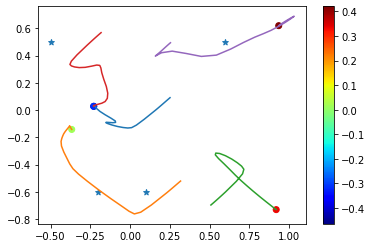

In [302]:
plot_trajectories(smallest_neg_eigenvalue_row)

### Second order optimization starting with the point of convergence.

Firstly, we fetch the weights from the student network.

In [303]:
w_in = []
w_out = []

for i in range(0, int(smallest_neg_eigenvalue_row['student size'])):
  neuron_traj_x = np.fromstring(smallest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
  neuron_traj_y = np.fromstring(smallest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')

  w_in.append([neuron_traj_x[-1], neuron_traj_y[-1]])

  w_out.append(float(smallest_neg_eigenvalue_row['neuron_' + str(i) + '_a'].values[0]))

w_out = [w_out]

print(w_in)
print(w_out)

[[-0.22891507, 0.027737318], [-0.36715215, -0.14208694], [0.91911304, -0.73121065], [-0.22889516, 0.027798353], [0.93499786, 0.62031204]]
[[-0.46414444, 0.019733509, 0.3374083, -0.31379378, 0.42078778]]


Secondly, we apply second order optimization from these weights.



In [304]:
params = OrderedDict([("w_in", torch.Tensor(w_in)), ("w_out", torch.Tensor(w_out))])
lb_dict = OrderedDict([("w_in", torch.Tensor(w_in) - 1), ("w_out", torch.Tensor(w_out) - 1)])
ub_dict = OrderedDict([("w_in", torch.Tensor(w_in) + 1), ("w_out", torch.Tensor(w_out) + 1)])
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
loss_before_optimization = nn.MSELoss()(dummy_model(dataset), y_labels).item()
print('loss before optimization: ', loss_before_optimization)
print('old params: ', params)
# params = minimize(d_loss, params, method="", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 3}, tol=1e-8)
params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
                  options={"disp": True , "maxiter": 10 ** 4}, tol=1e-60)
print('new params: ', params)

loss before optimization:  0.00011678227019729093
old params:  OrderedDict([('w_in', tensor([[-0.2289,  0.0277],
        [-0.3672, -0.1421],
        [ 0.9191, -0.7312],
        [-0.2289,  0.0278],
        [ 0.9350,  0.6203]])), ('w_out', tensor([[-0.4641,  0.0197,  0.3374, -0.3138,  0.4208]]))])
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0001167822556453757
            Iterations: 2
            Function evaluations: 15
            Gradient evaluations: 2
new params:  OrderedDict([('w_in', tensor([[-0.2289,  0.0277],
        [-0.3672, -0.1421],
        [ 0.9191, -0.7312],
        [-0.2289,  0.0278],
        [ 0.9350,  0.6203]], requires_grad=True)), ('w_out', tensor([[-0.4641,  0.0197,  0.3374, -0.3138,  0.4208]], requires_grad=True))])


New smallest eigenvalue after second order optimization.

In [305]:
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
print('loss after optimization: ', nn.MSELoss()(dummy_model(dataset), y_labels))
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm,   hessian = eval_hessian(loss_grad, dummy_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
print('new smallest eigenvelue:', smallest_eigenvalue)

loss after optimization:  tensor(0.0001, grad_fn=<MseLossBackward0>)
new smallest eigenvelue: -2.573106e-05


## Choose an experiment with the (negative) eigenvalue with the smallest magnitude - indicative of a local/global minimum.

In [306]:
highest_neg_eigenvalue_row = negative_eigenvalues_data[negative_eigenvalues_data['smallest eigenvalue'] == 
                          max(negative_eigenvalues_data['smallest eigenvalue'])]
highest_neg_eigenvalue_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,teacher_neurons_x,teacher_neurons_y
735,0.000048,0.000002,-8.671902e-11,5,"[-0.90857196, -0.90747195, -0.9064724, -0.9054...","[-0.004009843, -0.0029106995, -0.0019153812, -...",0.815155,"[0.56349933, 0.56459904, 0.56559724, 0.5665929...","[-0.5952005, -0.59410083, -0.59310293, -0.5921...",0.331791,"[0.6983309, 0.6994304, 0.70042783, 0.7014216, ...","[-0.31921273, -0.31811345, -0.31711724, -0.316...",0.221378,"[-0.8815908, -0.8826906, -0.8836895, -0.884687...","[0.41154468, 0.41044503, 0.40944687, 0.4084513...",-1.442998,"[-0.59875107, -0.5976512, -0.596652, -0.595653...","[0.4803276, 0.48142725, 0.48242548, 0.48342133...",0.075086,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


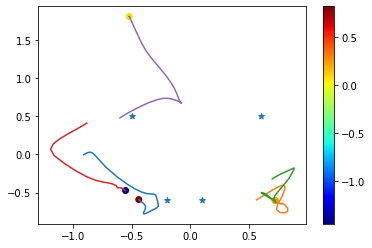

In [307]:
plot_trajectories(highest_neg_eigenvalue_row)

### Second order optimization starting with the point of convergence.

Firstly, we fetch the weights from the student network.

In [308]:
w_in = []
w_out = []

for i in range(0, int(highest_neg_eigenvalue_row['student size'])):
  neuron_traj_x = np.fromstring(highest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
  neuron_traj_y = np.fromstring(highest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')

  w_in.append([neuron_traj_x[-1], neuron_traj_y[-1]])

  w_out.append(float(highest_neg_eigenvalue_row['neuron_' + str(i) + '_a'].values[0]))

w_out = [w_out]

print(w_in)
print(w_out)

[[-0.43876052, -0.59079546], [0.72210443, -0.60179526], [0.72210443, -0.60179526], [-0.5514223, -0.47291625], [-0.52102506, 1.8085183]]
[[0.8151552, 0.33179128, 0.22137819, -1.4429983999999998, 0.07508643]]


Secondly, we apply second order optimization from these weights.



In [309]:
params = OrderedDict([("w_in", torch.Tensor(w_in)), ("w_out", torch.Tensor(w_out))])
lb_dict = OrderedDict([("w_in", torch.Tensor(w_in) - 1), ("w_out", torch.Tensor(w_out) - 1)])
ub_dict = OrderedDict([("w_in", torch.Tensor(w_in) + 1), ("w_out", torch.Tensor(w_out) + 1)])
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
loss_before_optimization = nn.MSELoss()(dummy_model(dataset), y_labels).item()
print('loss before optimization: ', loss_before_optimization)
print('old params: ',params)
# params = minimize(d_loss, params, method="", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 3}, tol=1e-8)
params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
                  options={"disp": True , "maxiter": 10 ** 4}, tol=1e-60)
print('new params: ',params)

loss before optimization:  4.78385372844059e-05
old params:  OrderedDict([('w_in', tensor([[-0.4388, -0.5908],
        [ 0.7221, -0.6018],
        [ 0.7221, -0.6018],
        [-0.5514, -0.4729],
        [-0.5210,  1.8085]])), ('w_out', tensor([[ 0.8152,  0.3318,  0.2214, -1.4430,  0.0751]]))])
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.709375571110286e-05
            Iterations: 85
            Function evaluations: 107
            Gradient evaluations: 85
new params:  OrderedDict([('w_in', tensor([[-0.4664, -0.5500],
        [ 0.7237, -0.6018],
        [ 0.7235, -0.6016],
        [-0.5255, -0.4916],
        [-0.5236,  1.8065]], requires_grad=True)), ('w_out', tensor([[ 1.8152,  0.3316,  0.2214, -2.4422,  0.0745]], requires_grad=True))])


New smallest eigenvalue after second order optimization.

In [310]:
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
print('loss after optimization: ', nn.MSELoss()(dummy_model(dataset), y_labels))
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
print('new smallest eigenvelue:', smallest_eigenvalue)

loss after optimization:  tensor(4.7094e-05, grad_fn=<MseLossBackward0>)
new smallest eigenvelue: 2.277758e-07


# How many are global minima?

In [311]:
len(data[data['loss'] <= 1e-8])

33